# Reaction Networks #

This code makes use of the ReactionNetwork class to store all information about a system needed to preform a simulation.
The ReactionNetwork can be constructed from an input file containing pairwise rules binding rules, and will build the full set of rules for that
system, disallowing sterically hindered interactions and using one-step binding.

### Input Files ###

Input files we're inspired by bngl but have diverged since they require less information. The sections are as follows:
- **parameters:** Variables to be used in the rest of the file, with whitespace between variable name and value on the same line. There are also reserved parameters, for instance setting `default_assoc` will change the initial `k_on` values used.
- **species:** The initial copies or concentrations of different species in the system. Currently, only supports setting monomer
copy numbers, but other species may be set programmatically later. e.g. `A(a) init_population`
- **observables:** Species to track throughout the simulation. By default Monomers at the largest (fully assembled) complex are tracked.
- **rules:** Binding rules. Note that only pairwise monomer binding rules of the form `A(a)+B(a)<->A(a!1).B(a!1)` are allowed.
The line can either be `rule_def` `association_constant` `dissociation_constant` or `rule_def` `G="DELTA_G_VALUE"`. No whitespace
should be used within the paramters.

Example input files can be found in `steric_free_simulator/input_files`

### Network Construction ###

The reaction network itself stores data in a graph explicitly represented using the NetworkX Module. (see networkx docs).
Networkx represents graphs as nested python dictionaries, and provides functions for efficiently searching and manipulating them.
Each node $S$ in the network is a species in the system, identified by a unique integer ID. Associated with each $S$ are the following
node attributes:

- **`copies:`** The number of this species currently present in the system
- **`struct`**: An undirected Networkx Graph representing the full structure (edges / interfaces and nodes / subunits) of this species.
- **`score`**: (optional) The free energy of this species

Each direct edge $E$ represents a source node $U$'s membership in a reaction to produce target node $V$. Each E has the following edge attributes:

- **`uid:`** A identifier unique to edges that are part of the same reaction. Two edges with the same `uid` must have the same target,
but all edges that end on a single target need not have the same `uid`. Essentially, if two source nodes have the same`uid`, then they are co-reactants in
the same reaction.
- **`k_on:`** The association constant for this reaction. Must be the same for edges with the same `uid`
- **`k_off:`** The dissociation constant for this reaction.
- **`rxn_score:`** The change in energy score for this reaction. Proportional to $\Delta G$. In a simulation, `k_on`, `k_off`, and
 `rxn_score` * `scalar_constant` are constrained thermodynamically

The advantage to using networkx representation is it is very easy to manipulate and very clear to the user. It is also a useful
format for constructing the network from pairwise rules for these reasons.

### Demonstrate Loading Trimer Network ###
First we import the reaction network class and construct it from the trimer input file. Calling the reaction networks `resolve_tree` method
will build the ful reaction network from the pairwise rules. If energies were set for the pairwise rules, it will assign energies to all reactions.

In [3]:
import sys
sys.path.append("../../")
from steric_free_simulator import ReactionNetwork
rn = ReactionNetwork('../input_files/trimer.pwr', one_step=True)
rn.resolve_tree()

KeyError: 'default_assoc'

Let's peer into the inner workings a little. First we can look at the `allowed_edges`, a dictionary storing the original pairwise rules. The keys are pairs
of subunits that can interact, and the values are a list of [k_on, k_off, rxn_score].

In [2]:
print(rn.allowed_edges)


{('A', 'B'): [None, None, 1, tensor([-5.], dtype=torch.float64)], ('A', 'C'): [None, None, 1, tensor([10.], dtype=torch.float64)], ('B', 'C'): [None, None, 1, tensor([-10.], dtype=torch.float64)]}


Let's take a look at the actual reaction graph, stored as a networkx DiGraph in the `network` attribute. Each node has an integer identifier,
with an associated dictionary of attributes. Here each node has a 'struct' and 'copies' attribute. We can also look at the structure of individual nodes / species:

Below is the set of Nodes with associated data
[(0, {'struct': <networkx.classes.graph.Graph object at 0x7fc1d365b0b8>, 'copies': tensor([5.], dtype=torch.float64)}), (1, {'struct': <networkx.classes.graph.Graph object at 0x7fc2a0267550>, 'copies': tensor([5.], dtype=torch.float64)}), (2, {'struct': <networkx.classes.graph.Graph object at 0x7fc2a02677f0>, 'copies': tensor([5.], dtype=torch.float64)}), (3, {'struct': <networkx.classes.graph.Graph object at 0x7fc2f64e8b38>, 'copies': tensor([0.], dtype=torch.float64)}), (4, {'struct': <networkx.classes.graph.Graph object at 0x7fc1d2d41358>, 'copies': tensor([0.], dtype=torch.float64)}), (5, {'struct': <networkx.classes.graph.Graph object at 0x7fc1d2d4b7f0>, 'copies': tensor([0.], dtype=torch.float64)}), (6, {'struct': <networkx.classes.graph.Graph object at 0x7fc2a02677b8>, 'copies': tensor([0.], dtype=torch.float64)})]
The trimer network has 7 possible species
The last node in the network node list is always the full complex. Lets look 

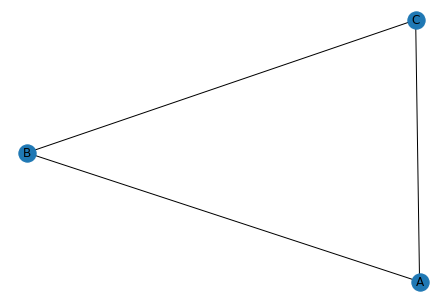

In [3]:
import networkx as nx
print("Below is the set of Nodes with associated data")
print(rn.network.nodes(data=True))
print('The trimer network has ' + str(len(rn.network)) + ' possible species')
print('The last node in the network node list is always the full complex. Lets look at its structure:')
nx.draw(rn.network.nodes[7-1]['struct'], with_labels=True)

We can also draw the full reaction network:

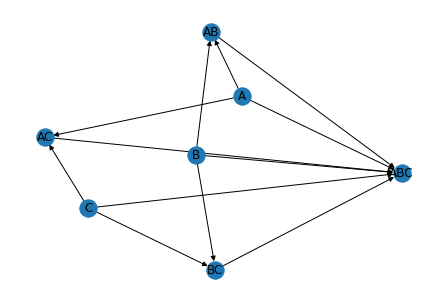

In [4]:
from steric_free_simulator.reaction_network import gtostr
labels = nx.get_node_attributes(rn.network, 'struct')
labels = {key:gtostr(labels[key]) for key in labels.keys()}
nx.draw(rn.network, labels=labels)


These reaction networks are great for visualization, exploration and manipulation. Simulations can even run directly on
them fairly quickly due to networkx's very flexible bidirectional HashMap structure. However, for our purposes we need
to be much faster, which is where the more specialized VectorizedReactionNetwork comes in.
